In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
games_df = pd.read_csv('C:/Guvi/Video_Game_Analysis/data/games.csv')
sales_df = pd.read_csv('C:/Guvi/Video_Game_Analysis/data/vgsales.csv')

print("Games dataset info:")
games_df.info()
print("\nSales dataset info:")
sales_df.info()

Games dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1512 non-null   int64  
 1   Title              1512 non-null   object 
 2   Release Date       1512 non-null   object 
 3   Team               1511 non-null   object 
 4   Rating             1499 non-null   float64
 5   Times Listed       1512 non-null   object 
 6   Number of Reviews  1512 non-null   object 
 7   Genres             1512 non-null   object 
 8   Summary            1511 non-null   object 
 9   Reviews            1512 non-null   object 
 10  Plays              1512 non-null   object 
 11  Playing            1512 non-null   object 
 12  Backlogs           1512 non-null   object 
 13  Wishlist           1512 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 165.5+ KB

Sales dataset info:
<class 'pandas.core

In [2]:
games_df.rename(columns={"Release Date": "release_date"}, inplace=True)
games_df.rename(columns={"Times Listed": "times_listed"}, inplace=True)
games_df.rename(columns={"Number of Reviews": "number_of_reviews"}, inplace=True)
games_df.rename(columns={"Release Year": "release_year"}, inplace=True)
games_df['release_date'] = pd.to_datetime(games_df['release_date'], errors='coerce') 
games_df['Team'] = games_df['Team'].str.replace(r"['\"\[\],]", "", regex=True)
games_df['Reviews'] = games_df['Team'].str.replace(r"['\"\[\]]", "", regex=True) 
games_df['Summary'] = games_df['Summary'].fillna('No summary available')
games_df['Rating'] = games_df['Rating'].fillna(games_df['Rating'].median())
games_df.rename(columns={"": "game_id"})

def clean_k_values(col):
    if isinstance(col, str):
        if 'K' in col:
            return float(col.replace('K', '')) * 1000
        return float(col)
    return col

numerical_cols = ['times_listed', 'number_of_reviews', 'Plays', 'Playing', 'Backlogs', 'Wishlist']
for col in numerical_cols:
    games_df[col] = games_df[col].apply(clean_k_values)
    games_df[col] = pd.to_numeric(games_df[col], errors='coerce')
    games_df[col] = games_df[col].fillna(games_df[col].median())


def clean_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str) if isinstance(genre_str, str) else genre_str
        if isinstance(genres, list):
            return ', '.join(genres)
        return str(genres)
    except:
        return str(genre_str)

games_df['Genres'] = games_df['Genres'].apply(clean_genres)





print("Data cleaning completed successfully!")
print("\nSample cleaned data:")
print(games_df.head(3))

Data cleaning completed successfully!

Sample cleaned data:
   Unnamed: 0                                    Title release_date  \
0           0                               Elden Ring   2022-02-25   
1           1                                    Hades   2019-12-10   
2           2  The Legend of Zelda: Breath of the Wild   2017-03-03   

                                           Team  Rating  times_listed  \
0       Bandai Namco Entertainment FromSoftware     4.5        3900.0   
1                              Supergiant Games     4.3        2900.0   
2  Nintendo Nintendo EPD Production Group No. 3     4.4        4300.0   

   number_of_reviews                          Genres  \
0             3900.0                  Adventure, RPG   
1             2900.0  Adventure, Brawler, Indie, RPG   
2             4300.0                  Adventure, RPG   

                                             Summary  \
0  Elden Ring is a fantasy, action and open world...   
1  A rogue-lite hack and 

In [3]:
games_df = games_df.loc[:, ~games_df.columns.str.contains('^Unnamed')]
games_df.to_csv('data/cleaned_games.csv', index=False)

In [4]:
# Handle missing values
sales_df.rename(columns={"Rank": "game_rank"}, inplace=True)
sales_df['Year'] = sales_df['Year'].fillna(sales_df['Year'].median()).astype(int)
sales_df['Publisher'] = sales_df['Publisher'].fillna('Unknown')
sales_df['Genre'] = sales_df['Genre'].fillna('Unknown')

# Clean platform names (standardize)
platform_cleanup = {
    'PS4': 'PlayStation 4',
    'PS3': 'PlayStation 3',
    'PS2': 'PlayStation 2',
    'PS': 'PlayStation',
    'PSV': 'PlayStation Vita',
    'X360': 'Xbox 360',
    'XB': 'Xbox',
    'XOne': 'Xbox One',
    'GC': 'GameCube',
    'GB': 'Game Boy Advance',
    'DS': 'Nintendo DS',
    '3DS': 'Nintendo 3DS',
    'Switch': 'Nintendo Switch',
    'Wii': 'Wii U'
}
sales_df['Platform'] = sales_df['Platform'].replace(platform_cleanup)

# Create decade column for temporal analysis
sales_df['Decade'] = (sales_df['Year'] // 10) * 10

In [5]:
sales_df.to_csv('data/cleaned_vgsales.csv', index=False)

In [4]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

connection_url = URL.create(
    drivername="mysql+pymysql",
    username="root",
    password="welcome@123",  # Handles special chars automatically
    host="localhost",
    port=3306,
    database="video_game_analysis"
)

engine = create_engine(connection_url)

In [5]:
# Test the connection
try:
    with engine.connect() as conn:
        print("✅ Connection successful!")
        # Check if tables exist
        if engine.dialect.has_table(conn, "games"):
            print("Found 'games' table")
        else:
            print("Creating 'games' table")
        
        # Insert your data
        games_df = pd.read_csv('C:/Guvi/Video_Game_Analysis/data/cleaned_games.csv')
        games_df.to_sql('games', engine, if_exists='append', index=False)
        print("Data inserted successfully!")
        
except Exception as e:
    print(f"❌ Connection failed: {e}")

✅ Connection successful!
Found 'games' table
Data inserted successfully!


In [8]:
try:
    with engine.connect() as conn:
        print("✅ Connection successful!")
        # Check if tables exist
        if engine.dialect.has_table(conn, "vgsales"):
            print("Found 'vgsales' table")
        else:
            print("Creating 'vgsales' table")
        
        # Insert your data
        games_df = pd.read_csv('C:/Guvi/Video_Game_Analysis/data/cleaned_vgsales.csv')
        games_df.to_sql('vgsales', engine, if_exists='append', index=False)
        print("Data inserted successfully!")
        
except Exception as e:
    print(f"❌ Connection failed: {e}")

✅ Connection successful!
Found 'vgsales' table
Data inserted successfully!


In [59]:


# Database connection
engine = create_engine(connection_url)
plt.style.use('ggplot')
sns.set_palette("viridis")



# 1. Read data functions
def read_games_data():
    try:
        with engine.connect() as connection:
            games_df = pd.read_sql_table('games', connection)
            print(f"✅ Successfully read {len(games_df)} games")
            return games_df
    except Exception as e:
        print(f"❌ Error reading games table: {e}")
        return None

def read_vgsales_data():
    try:
        with engine.connect() as connection:
            vgsales_df = pd.read_sql_table('vgsales', connection)
            print(f"✅ Successfully read {len(vgsales_df)} sales records")
            return vgsales_df
    except Exception as e:
        print(f"❌ Error reading vgsales table: {e}")
        return None

# Load data
games_data = read_games_data()
vgsales_data = read_vgsales_data()
    
   
    
    

✅ Successfully read 1512 games
✅ Successfully read 16598 sales records


C:\Users\Finton\AppData\Local\Temp\ipykernel_16556\3091466493.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='title', data=top_rated, palette='rocket')


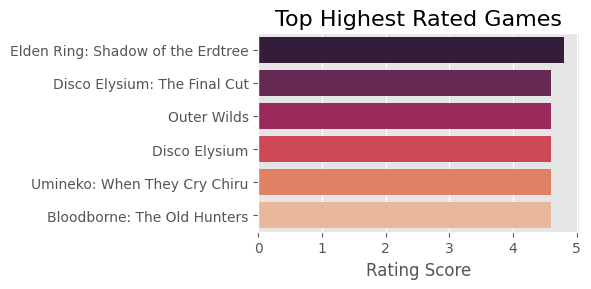

In [73]:
# 1. Top-rated games by user reviews
plt.figure(figsize=(6, 3))
top_rated = games_data.nlargest(10, 'rating')[['title', 'rating', 'number_of_reviews']]
sns.barplot(x='rating', y='title', data=top_rated, palette='rocket')
plt.title('Top Highest Rated Games', fontsize=16)
plt.xlabel('Rating Score', fontsize=12)
plt.ylabel('')
plt.tight_layout()
plt.show()



C:\Users\Finton\AppData\Local\Temp\ipykernel_16556\3379732136.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y=developer_stats.index, data=developer_stats, palette='mako')


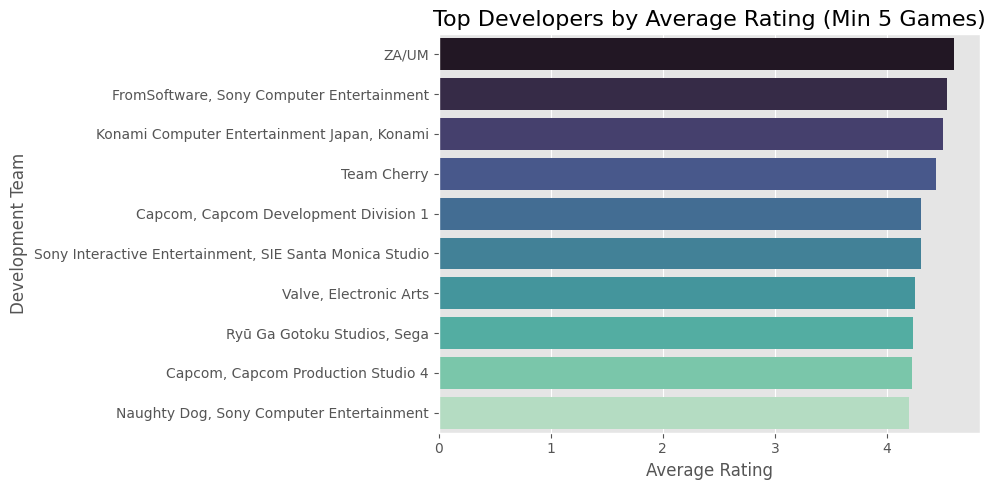

In [76]:
# 2. Developers with highest average ratings (min 5 games)

developer_stats = games_data.groupby('team').agg(
    avg_rating=('rating', 'mean'),
    game_count=('game_id', 'count')
).query('game_count >= 5').nlargest(10, 'avg_rating')

plt.figure(figsize=(10, 5))
sns.barplot(x='avg_rating', y=developer_stats.index, data=developer_stats, palette='mako')
plt.title('Top Developers by Average Rating (Min 5 Games)', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Development Team', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\Finton\AppData\Local\Temp\ipykernel_16556\2405892550.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='flare')


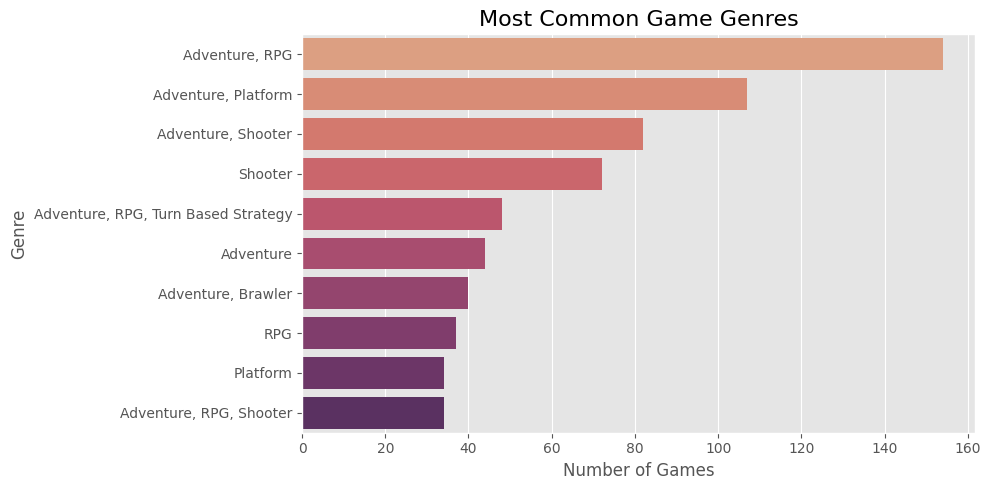

In [79]:
# 3. Most common genres
plt.figure(figsize=(10, 5))
 
genre_counts = games_data['genres'].value_counts().nlargest(10)
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='flare')
plt.title('Most Common Game Genres', fontsize=16)
plt.xlabel('Number of Games', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()



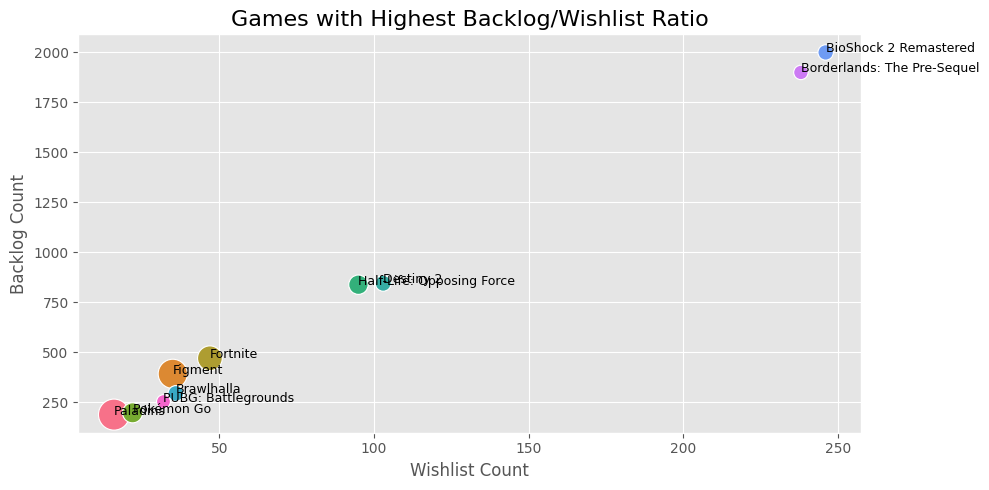

In [81]:
# 4. Games with highest backlog vs wishlist ratio
games_data['backlog_wishlist_ratio'] = games_data['backlogs'] / games_data['wishlist']
top_ratio = games_data.nlargest(10, 'backlog_wishlist_ratio')[['title', 'backlogs', 'wishlist', 'backlog_wishlist_ratio']]

plt.figure(figsize=(10, 5))
sns.scatterplot(x='wishlist', y='backlogs', size='backlog_wishlist_ratio',
                hue='title', data=top_ratio, sizes=(100, 500), legend=False)
plt.title('Games with Highest Backlog/Wishlist Ratio', fontsize=16)
plt.xlabel('Wishlist Count', fontsize=12)
plt.ylabel('Backlog Count', fontsize=12)
for i, row in top_ratio.iterrows():
    plt.text(row['wishlist'], row['backlogs'], row['title'], fontsize=9)
plt.tight_layout()
plt.show()

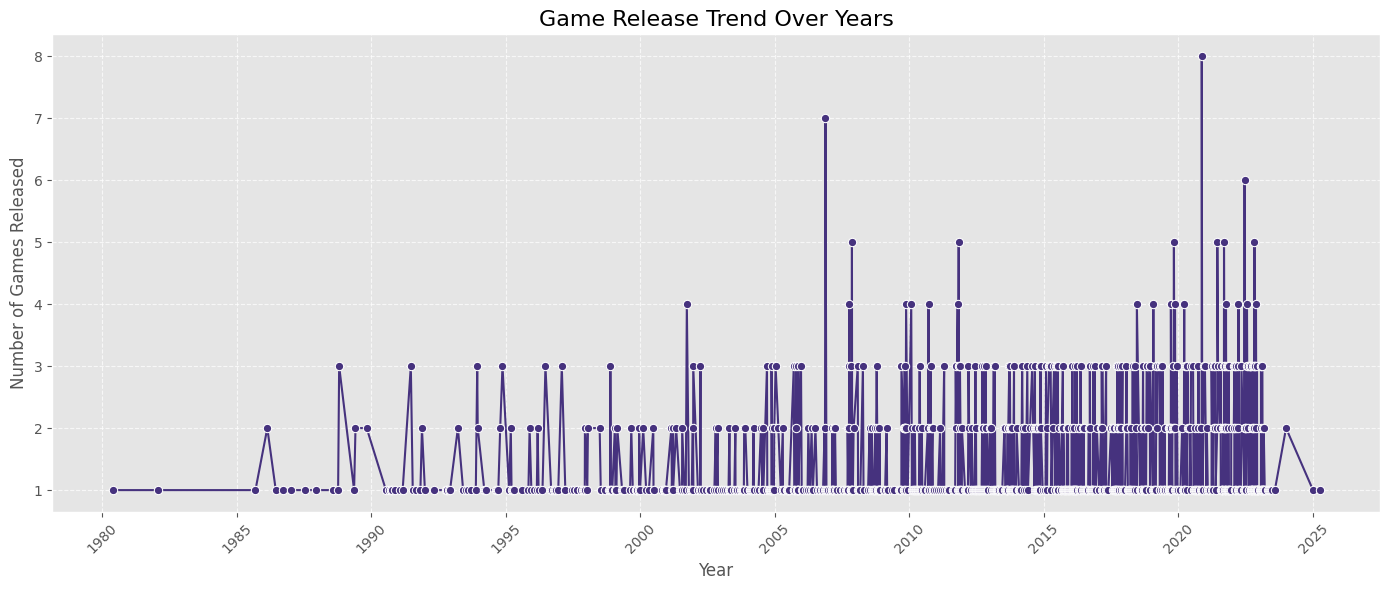

In [83]:
# 5. Game release trend by year
plt.figure(figsize=(14, 6))
release_trend = games_data['release_date'].value_counts().sort_index()
sns.lineplot(x=release_trend.index, y=release_trend.values, marker='o')
plt.title('Game Release Trend Over Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Games Released', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

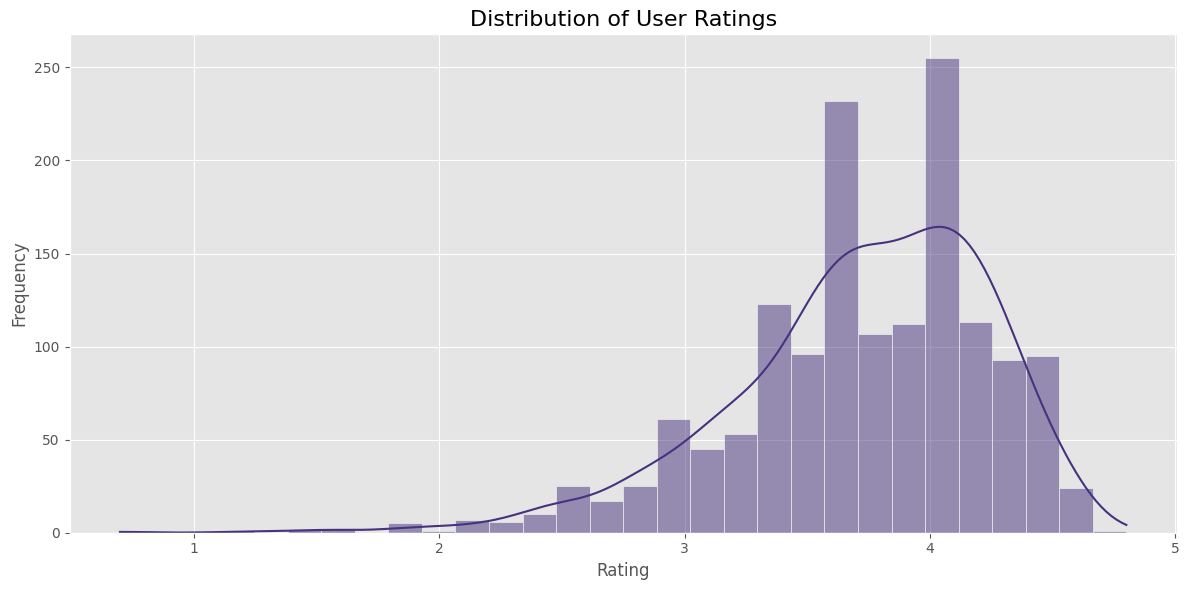

In [84]:
# 6. Distribution of user ratings
plt.figure(figsize=(12, 6))
sns.histplot(games_data['rating'], bins=30, kde=True)
plt.title('Distribution of User Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\Finton\AppData\Local\Temp\ipykernel_16556\2299580703.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='wishlist', y='title', data=top_wishlist, palette='viridis')


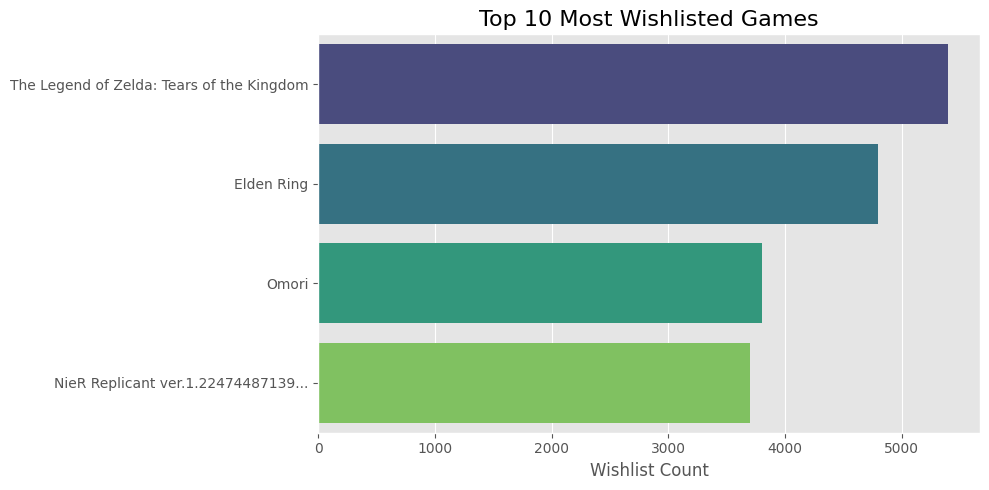

In [86]:

# 7. Top 10 most wishlisted games
plt.figure(figsize=(10, 5))
top_wishlist = games_data.nlargest(10, 'wishlist')[['title', 'wishlist']]
sns.barplot(x='wishlist', y='title', data=top_wishlist, palette='viridis')
plt.title('Top 10 Most Wishlisted Games', fontsize=16)
plt.xlabel('Wishlist Count', fontsize=12)
plt.ylabel('')
plt.tight_layout()
plt.show()

C:\Users\Finton\AppData\Local\Temp\ipykernel_16556\2267852811.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_plays.values, y=genre_plays.index, palette='crest')


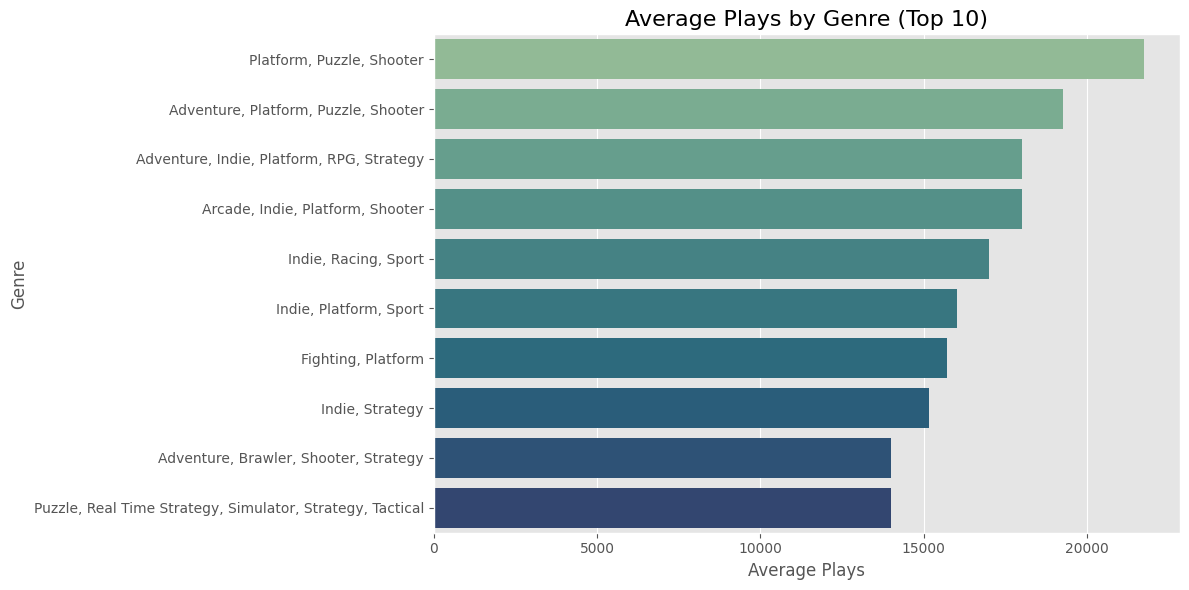

In [87]:
# 8. Average plays per genre
genre_plays = games_data.groupby('genres')['plays'].mean().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_plays.values, y=genre_plays.index, palette='crest')
plt.title('Average Plays by Genre (Top 10)', fontsize=16)
plt.xlabel('Average Plays', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

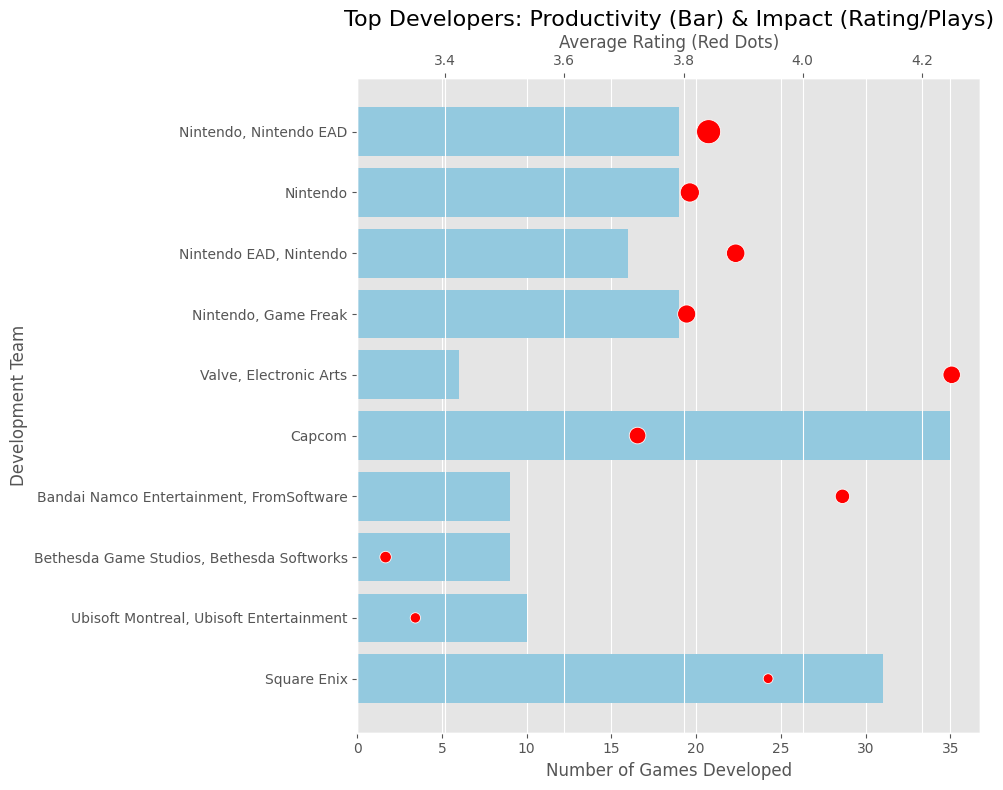

In [89]:
# 9. Most productive and impactful developers
developer_stats = games_data.groupby('team').agg(
    game_count=('game_id', 'count'),
    avg_rating=('rating', 'mean'),
    total_plays=('plays', 'sum')
).query('game_count >= 5').nlargest(10, 'total_plays')

fig, ax1 = plt.subplots(figsize=(10, 8))
sns.barplot(x='game_count', y=developer_stats.index, data=developer_stats, ax=ax1, color='skyblue')
ax2 = ax1.twiny()
sns.scatterplot(x='avg_rating', y=np.arange(len(developer_stats)), 
                size='total_plays', data=developer_stats, ax=ax2, 
                color='red', sizes=(50, 300), legend=False)
ax1.set_title('Top Developers: Productivity (Bar) & Impact (Rating/Plays)', fontsize=16)
ax1.set_xlabel('Number of Games Developed', fontsize=12)
ax2.set_xlabel('Average Rating (Red Dots)', fontsize=12)
ax1.set_ylabel('Development Team', fontsize=12)
plt.tight_layout()
plt.show()

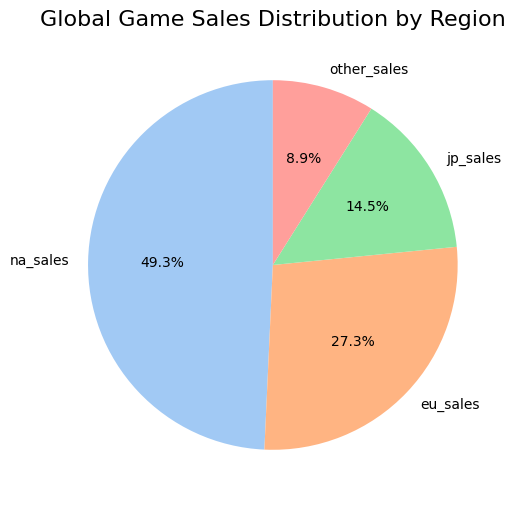

In [91]:
# 1. Sales by region (pie chart)
region_sales = vgsales_data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()
plt.figure(figsize=(6, 6))
plt.pie(region_sales, labels=region_sales.index, autopct='%1.1f%%',
        colors=sns.color_palette('pastel'), startangle=90)
plt.title('Global Game Sales Distribution by Region', fontsize=16)
plt.show()

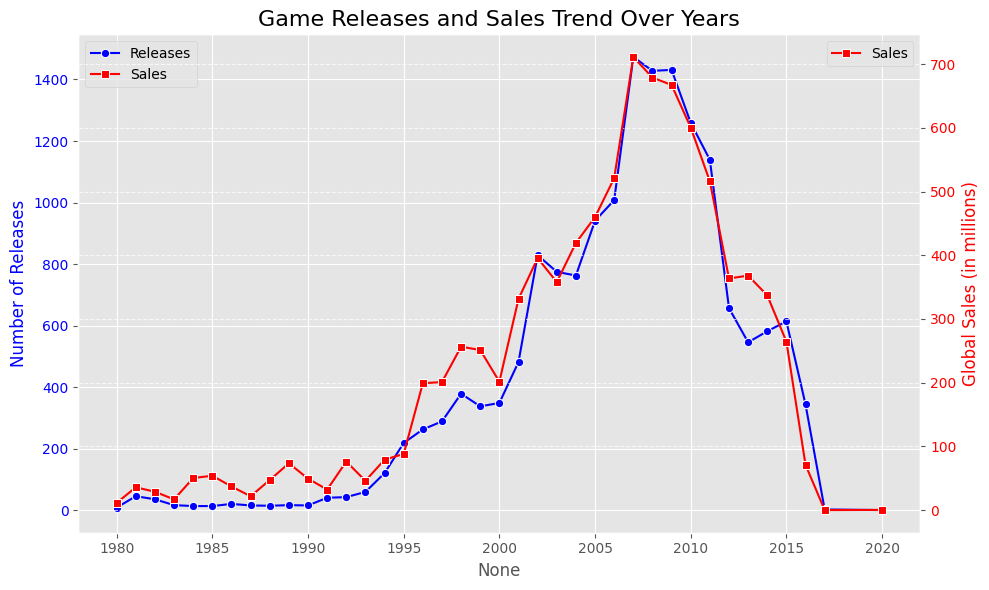

In [94]:
# 3. Trend of game releases and sales over years
fig, ax1 = plt.subplots(figsize=(10, 6))

# Release count
release_counts = vgsales_data['year'].value_counts().sort_index()
sns.lineplot(x=release_counts.index, y=release_counts.values, 
             color='blue', ax=ax1, label='Releases', marker='o')
ax1.set_ylabel('Number of Releases', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Sales volume
ax2 = ax1.twinx()
sales_trend = vgsales_data.groupby('year')['global_sales'].sum()
sns.lineplot(x=sales_trend.index, y=sales_trend.values, 
             color='red', ax=ax2, label='Sales', marker='s')
ax2.set_ylabel('Global Sales (in millions)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
 

plt.title('Game Releases and Sales Trend Over Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\Finton\AppData\Local\Temp\ipykernel_16556\1565661396.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publisher_sales.values, y=publisher_sales.index, palette='viridis')


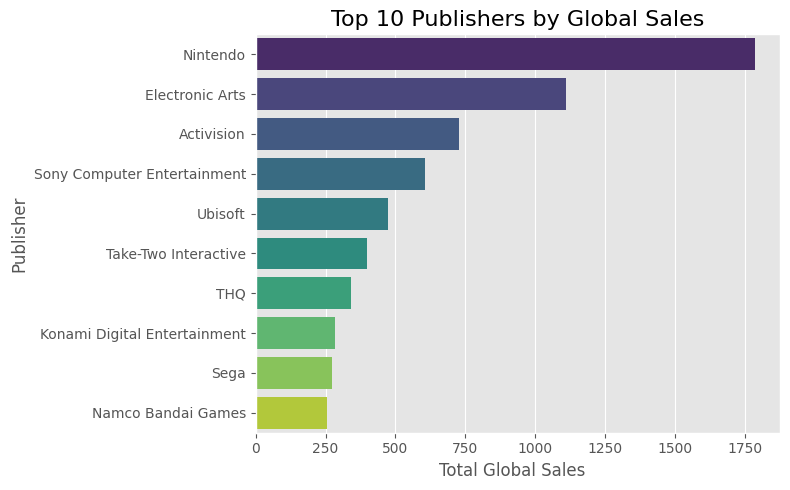

In [99]:
# 4. Top publishers by sales
publisher_sales = vgsales_data.groupby('publisher')['global_sales'].sum().nlargest(10)
plt.figure(figsize=(8, 5))
sns.barplot(x=publisher_sales.values, y=publisher_sales.index, palette='viridis')
plt.title('Top 10 Publishers by Global Sales', fontsize=16)
plt.xlabel('Total Global Sales  ', fontsize=12)
plt.ylabel('Publisher', fontsize=12) 
plt.tight_layout()
plt.show()

C:\Users\Finton\AppData\Local\Temp\ipykernel_16556\4069487742.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='global_sales', y='name', data=top_games, palette='mako')


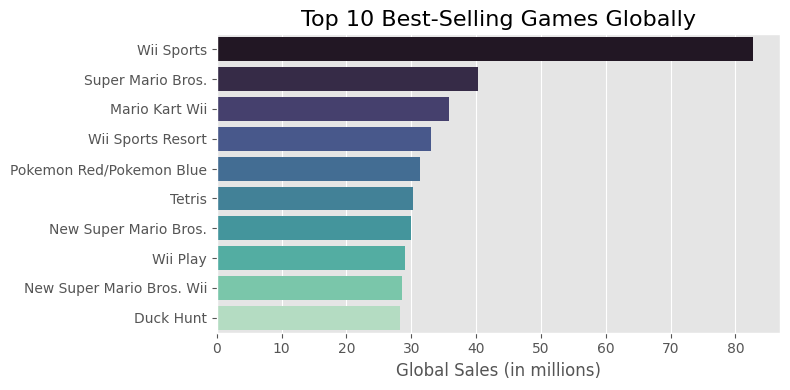

In [101]:
# 5. Top 10 best-selling games globally
top_games = vgsales_data.nlargest(10, 'global_sales')[['name', 'global_sales']]
plt.figure(figsize=(8, 4))
sns.barplot(x='global_sales', y='name', data=top_games, palette='mako')
plt.title('Top 10 Best-Selling Games Globally', fontsize=16)
plt.xlabel('Global Sales (in millions)', fontsize=12)
plt.ylabel('') 
plt.tight_layout()
plt.show()

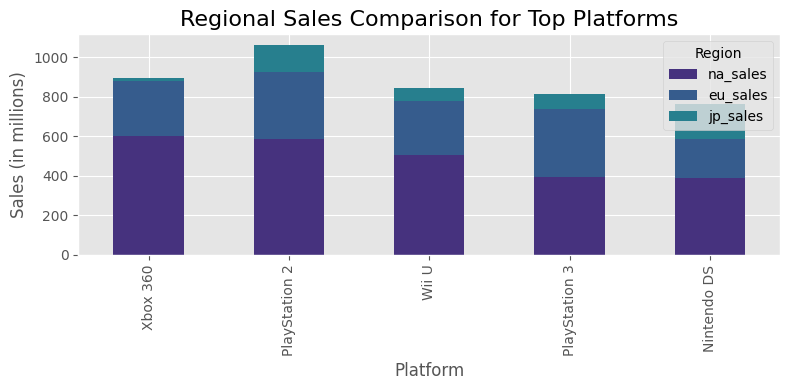

In [103]:
# 6. Regional sales comparison for platforms
platform_regional = vgsales_data.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales']].sum().nlargest(5, 'na_sales')
platform_regional.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('Regional Sales Comparison for Top Platforms', fontsize=16)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Sales (in millions)', fontsize=12)
plt.legend(title='Region') 
plt.tight_layout()
plt.show()

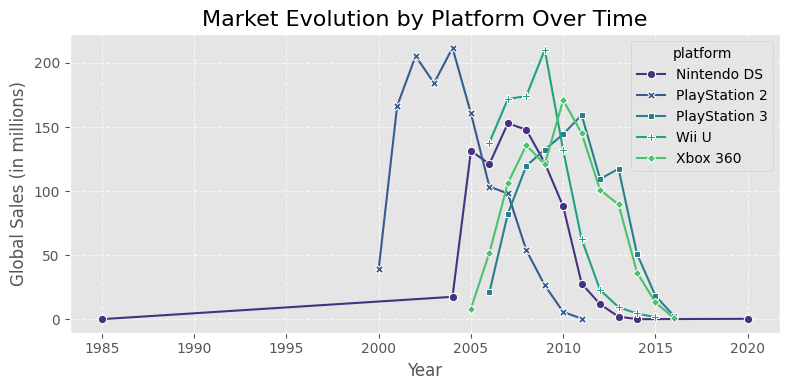

In [104]:
# 7. Market evolution by platform over time
top_platforms = vgsales_data['platform'].value_counts().nlargest(5).index
platform_evolution = vgsales_data[vgsales_data['platform'].isin(top_platforms)] \
    .groupby(['year', 'platform'])['global_sales'].sum().unstack()

plt.figure(figsize=(8, 4))
sns.lineplot(data=platform_evolution, dashes=False, markers=True)
plt.title('Market Evolution by Platform Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Global Sales (in millions)', fontsize=12) 
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

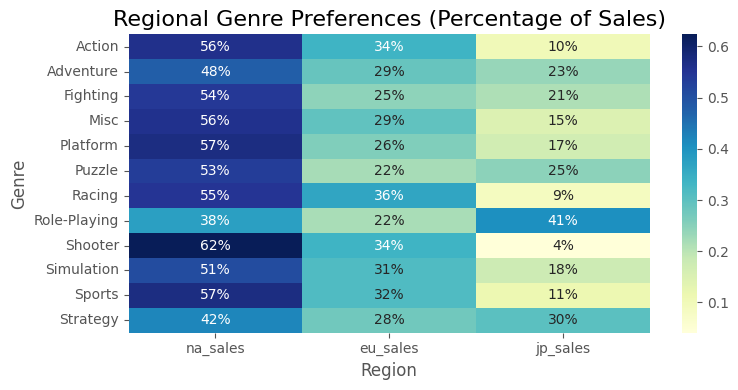

In [106]:
# 8. Regional genre preferences
genre_regional = vgsales_data.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum()
genre_regional = genre_regional.div(genre_regional.sum(axis=1), axis=0)  # Normalize

plt.figure(figsize=(8, 4))
sns.heatmap(genre_regional, cmap='YlGnBu', annot=True, fmt='.0%')
plt.title('Regional Genre Preferences (Percentage of Sales)', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

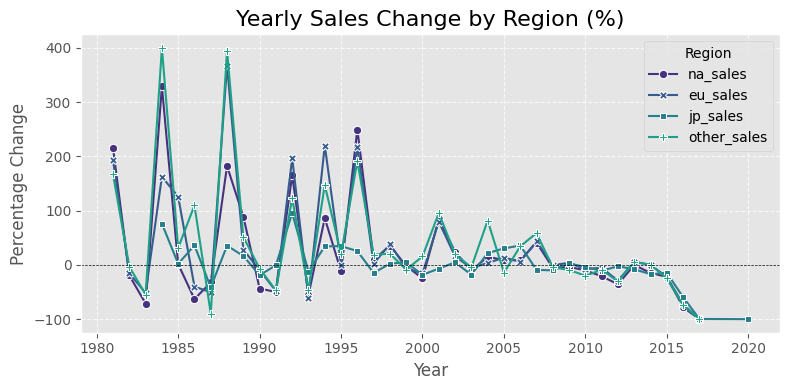

In [107]:
# 9. Yearly sales change per region
yearly_sales = vgsales_data.groupby('year')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()
yearly_change = yearly_sales.pct_change() * 100

plt.figure(figsize=(8, 4))
sns.lineplot(data=yearly_change, dashes=False, markers=True)
plt.title('Yearly Sales Change by Region (%)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage Change', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Region')
plt.tight_layout()
plt.show()

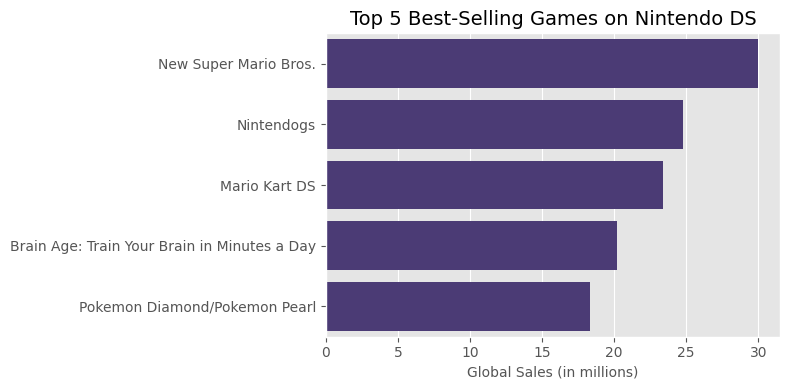

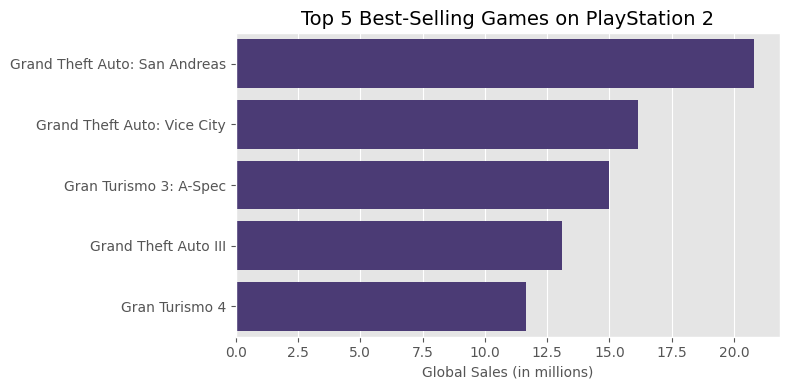

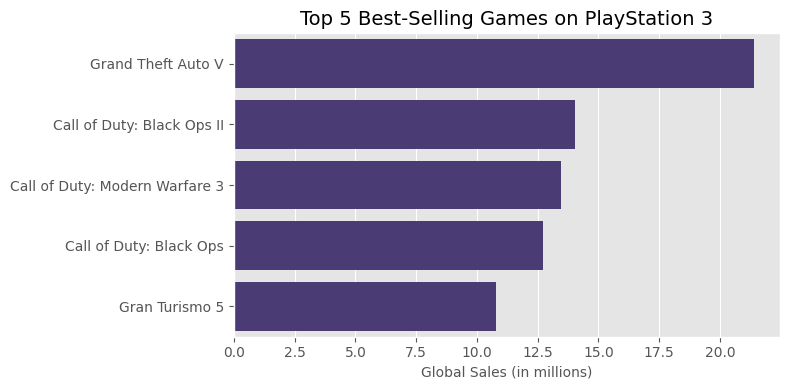

In [110]:
# 10. Top 5 best-selling games per platform
top_platforms = vgsales_data['platform'].value_counts().nlargest(3).index
for platform in top_platforms:
    platform_games = vgsales_data[vgsales_data['platform'] == platform] \
        .nlargest(5, 'global_sales')[['name', 'global_sales']]
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x='global_sales', y='name', data=platform_games)
    plt.title(f'Top 5 Best-Selling Games on {platform}', fontsize=14)
    plt.xlabel('Global Sales (in millions)', fontsize=10)
    plt.ylabel('')    
    plt.tight_layout()
    plt.show()

C:\Users\Finton\AppData\Local\Temp\ipykernel_16556\481950683.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_sales.values, y=genre_sales.index, palette='flare')


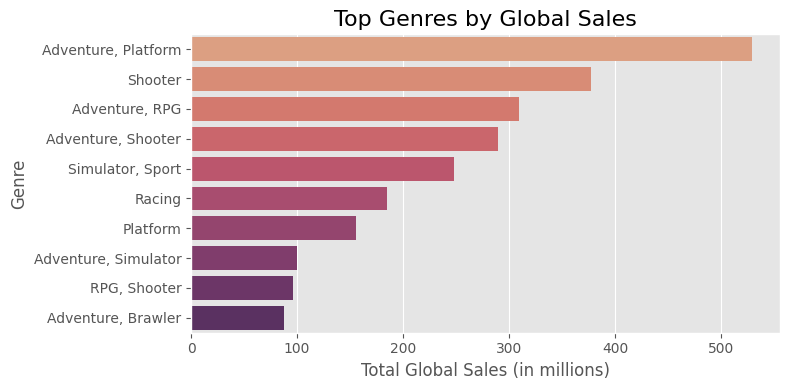

In [112]:
merged_data = pd.merge(games_data, vgsales_data, 
                      left_on='title', right_on='name', 
                      how='inner')

# 1. Genres with most global sales
genre_sales = merged_data.groupby('genres')['global_sales'].sum().nlargest(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=genre_sales.values, y=genre_sales.index, palette='flare')
plt.title('Top Genres by Global Sales', fontsize=16)
plt.xlabel('Total Global Sales (in millions)', fontsize=12)
plt.ylabel('Genre', fontsize=12) 
plt.tight_layout()
plt.show()

C:\Users\Finton\AppData\Local\Temp\ipykernel_16556\787597837.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


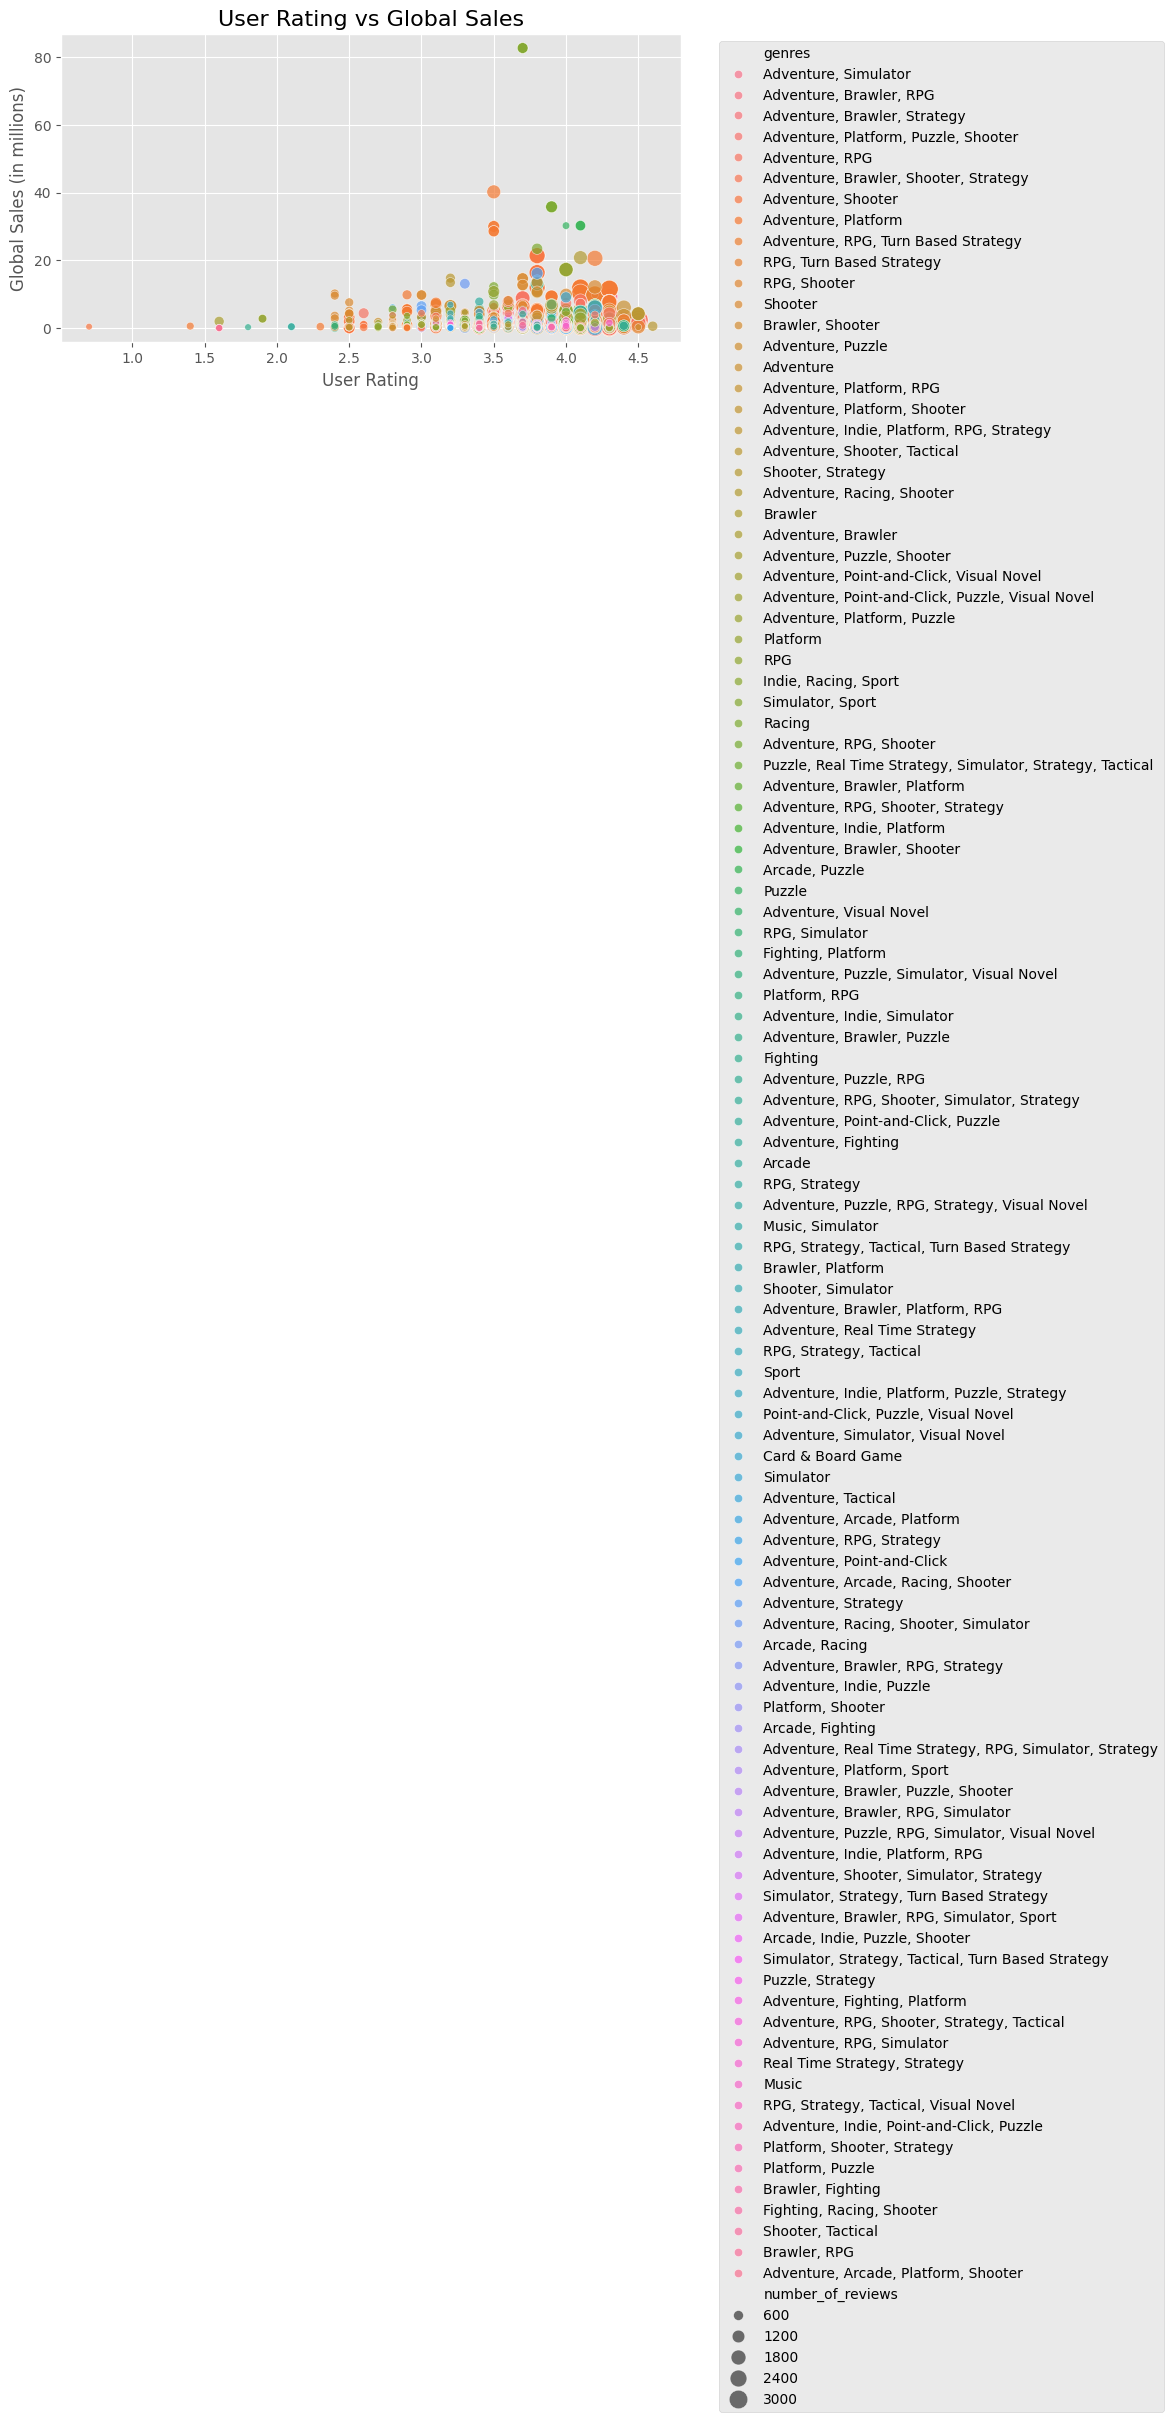

In [113]:
# 2. Rating vs global sales
plt.figure(figsize=(8, 4))
sns.scatterplot(x='rating', y='global_sales', hue='genres', 
                size='number_of_reviews', data=merged_data, 
                sizes=(20, 200), alpha=0.7)
plt.title('User Rating vs Global Sales', fontsize=16)
plt.xlabel('User Rating', fontsize=12)
plt.ylabel('Global Sales (in millions)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\Finton\AppData\Local\Temp\ipykernel_16556\3756275854.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_ratings.values, y=platform_ratings.index, palette='viridis')


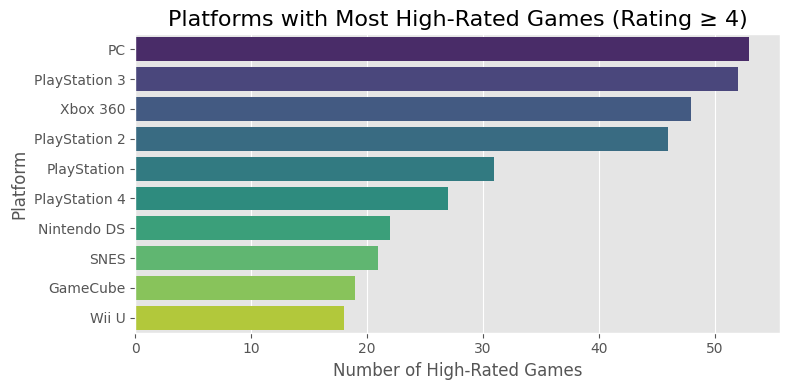

In [114]:
# 3. Platforms with most high-rated games
high_rated = merged_data[merged_data['rating'] >= 4]
platform_ratings = high_rated['platform'].value_counts().nlargest(10)

plt.figure(figsize=(8, 4))
sns.barplot(x=platform_ratings.values, y=platform_ratings.index, palette='viridis')
plt.title('Platforms with Most High-Rated Games (Rating ≥ 4)', fontsize=16)
plt.xlabel('Number of High-Rated Games', fontsize=12)
plt.ylabel('Platform', fontsize=12)
plt.tight_layout()
plt.show()

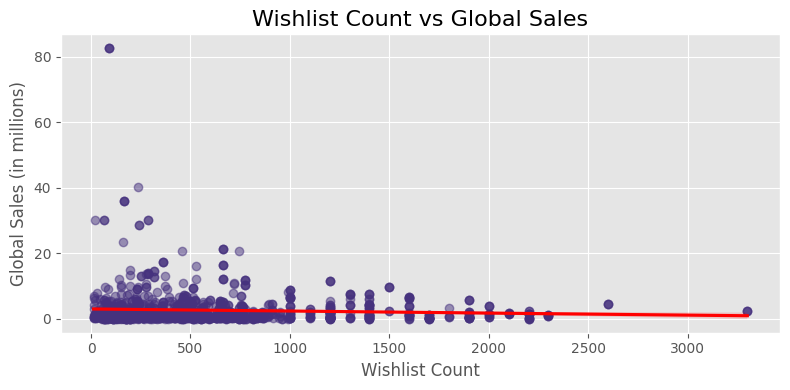

In [115]:
# 4. Wishlist vs sales correlation
plt.figure(figsize=(8, 4))
sns.regplot(x='wishlist', y='global_sales', data=merged_data, 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Wishlist Count vs Global Sales', fontsize=16)
plt.xlabel('Wishlist Count', fontsize=12)
plt.ylabel('Global Sales (in millions)', fontsize=12)

plt.tight_layout()
plt.show()

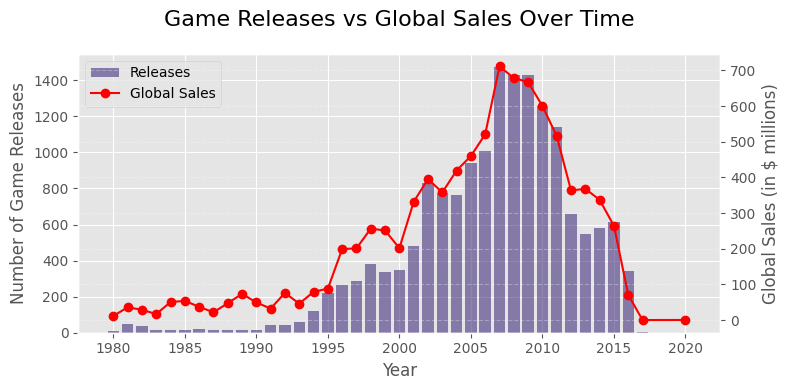

In [122]:
# 5. Trend of Releases and Sales Over Time (Combined Visualization)
plt.figure(figsize=(8, 4))

# Calculate metrics
releases_by_year = vgsales_data['year'].value_counts().sort_index()
sales_by_year = vgsales_data.groupby('year')['global_sales'].sum()

# Normalize for dual-axis plot
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot releases (bars)
ax1.bar(releases_by_year.index, releases_by_year.values, alpha=0.6, label='Releases')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Game Releases', fontsize=12)

# Plot sales (line)
ax2.plot(sales_by_year.index, sales_by_year.values, color='red', 
         marker='o', label='Global Sales')
ax2.set_ylabel('Global Sales (in $ millions)', fontsize=12)


plt.title('Game Releases vs Global Sales Over Time', fontsize=16, pad=20)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

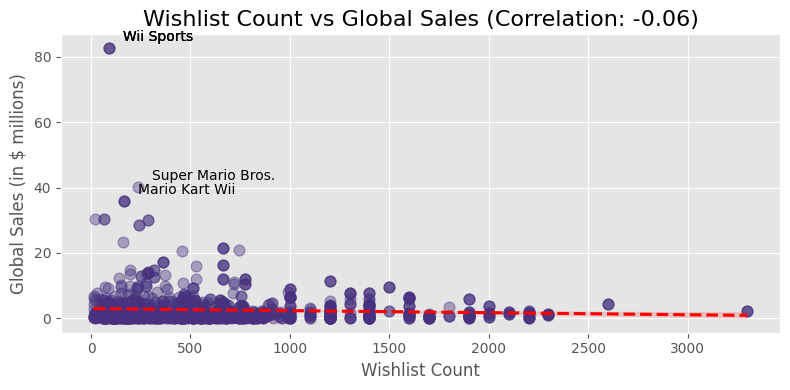

In [124]:
# 6. Wishlist vs Sales Correlation Analysis
plt.figure(figsize=(8, 4))

# Calculate correlation
correlation = merged_data[['wishlist', 'global_sales']].corr().iloc[0,1]

# Create enhanced scatter plot
scatter = sns.regplot(x='wishlist', y='global_sales', 
                      data=merged_data, 
                      scatter_kws={'alpha':0.4, 's':60},
                      line_kws={'color':'red', 'linestyle':'--'})

plt.title(f'Wishlist Count vs Global Sales (Correlation: {correlation:.2f})', fontsize=16)
plt.xlabel('Wishlist Count', fontsize=12)
plt.ylabel('Global Sales (in $ millions)', fontsize=12)


# Highlight top performers
top_games = merged_data.nlargest(5, 'global_sales')
for i, row in top_games.iterrows():
    plt.annotate(row['title'], (row['wishlist'], row['global_sales']),
                 xytext=(10,5), textcoords='offset points')

plt.tight_layout()
plt.show()

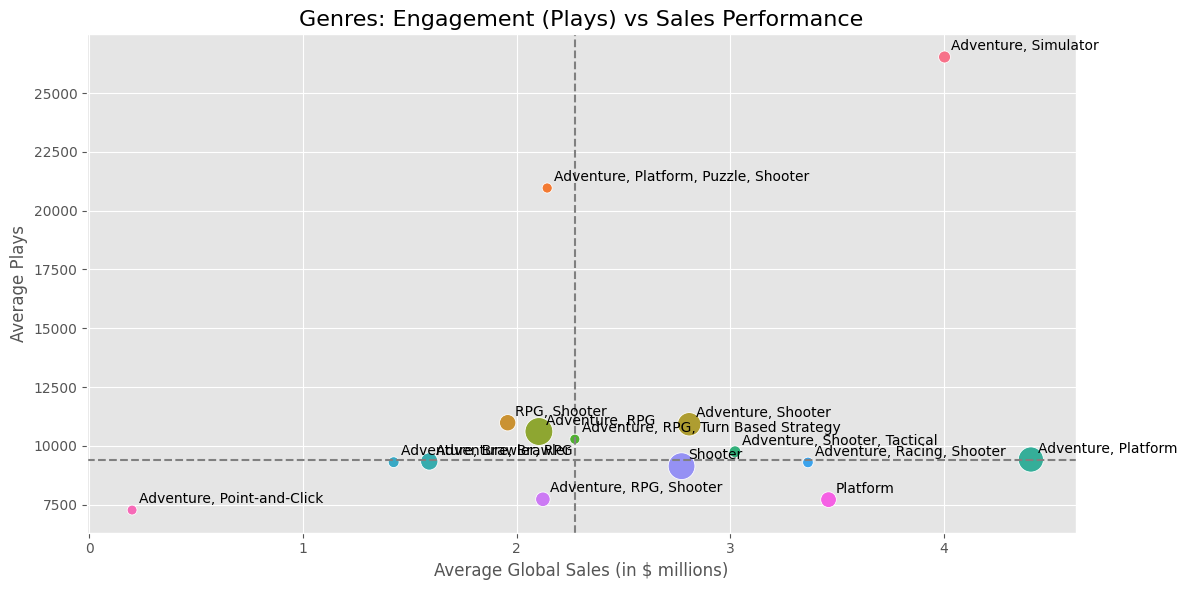

In [127]:
# 7. Genres with High Engagement but Low Sales (Bubble Chart)
genre_metrics = merged_data.groupby('genres').agg(
    avg_plays=('plays', 'mean'),
    avg_sales=('global_sales', 'mean'),
    count=('title', 'count')
).query('count >= 10').nlargest(15, 'avg_plays')

plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    x='avg_sales', 
    y='avg_plays', 
    size='count',
    sizes=(50, 400),
    hue=genre_metrics.index,
    data=genre_metrics,
    legend=False
)

plt.title('Genres: Engagement (Plays) vs Sales Performance', fontsize=16)
plt.xlabel('Average Global Sales (in $ millions)', fontsize=12)
plt.ylabel('Average Plays', fontsize=12)

# Annotate interesting genres
for i, row in genre_metrics.iterrows():
    plt.annotate(i, (row['avg_sales'], row['avg_plays']),
                 xytext=(5,5), textcoords='offset points')

plt.axvline(genre_metrics['avg_sales'].median(), linestyle='--', color='gray')
plt.axhline(genre_metrics['avg_plays'].median(), linestyle='--', color='gray')
plt.tight_layout()
plt.show()

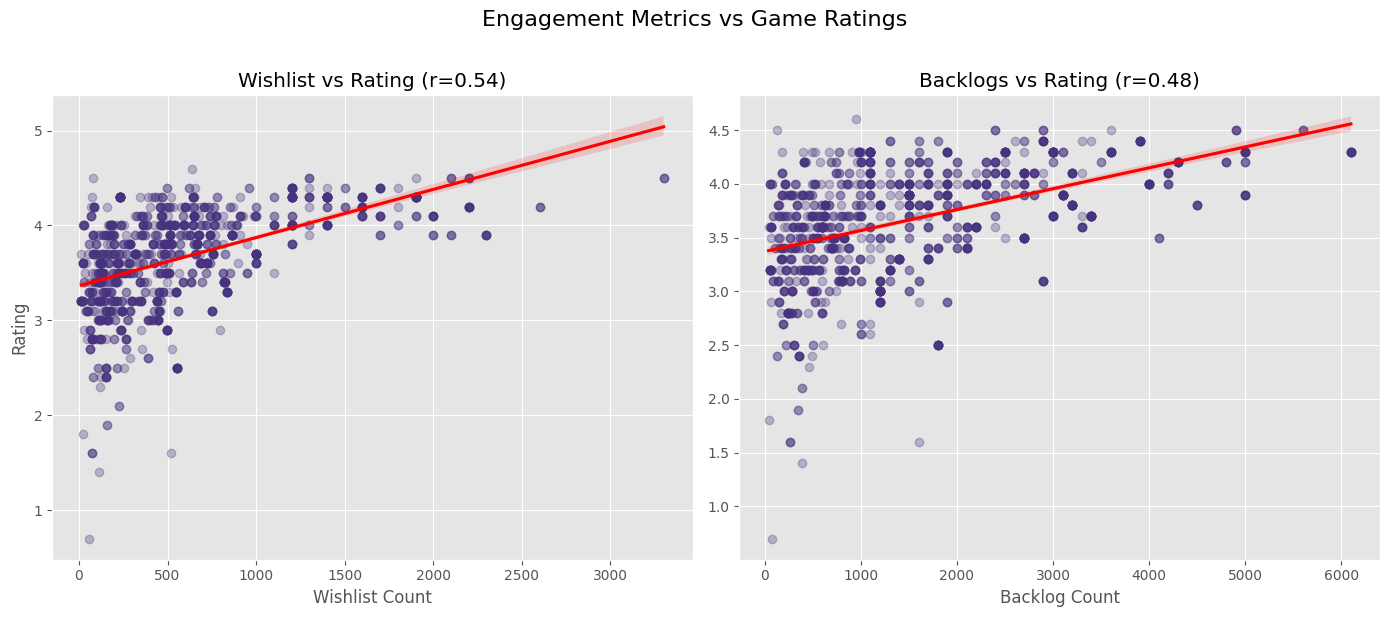

In [128]:
# 8. Wishlist/Backlogs vs Ratings Analysis
plt.figure(figsize=(14, 6))

# Create composite engagement metric
merged_data['engagement'] = merged_data['wishlist'] + merged_data['backlogs']

# Calculate correlations
corr_wishlist = merged_data['wishlist'].corr(merged_data['rating'])
corr_backlog = merged_data['backlogs'].corr(merged_data['rating'])

# Plot
plt.subplot(1, 2, 1)
sns.regplot(x='wishlist', y='rating', data=merged_data, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title(f'Wishlist vs Rating (r={corr_wishlist:.2f})')
plt.xlabel('Wishlist Count')
plt.ylabel('Rating')

plt.subplot(1, 2, 2)
sns.regplot(x='backlogs', y='rating', data=merged_data,
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title(f'Backlogs vs Rating (r={corr_backlog:.2f})')
plt.xlabel('Backlog Count')
plt.ylabel('')

plt.suptitle('Engagement Metrics vs Game Ratings', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

C:\Users\Finton\AppData\Local\Temp\ipykernel_16556\2002836426.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


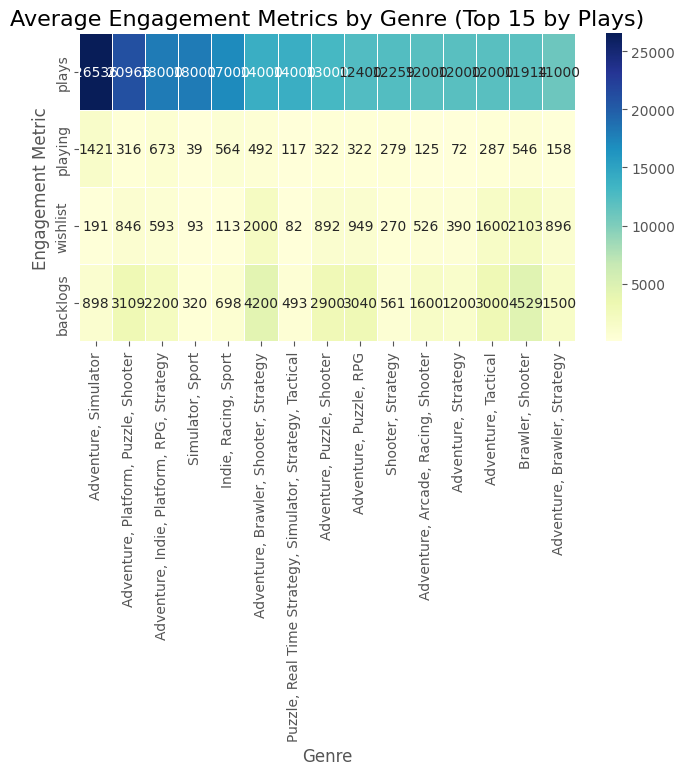

In [131]:
# 9. User Engagement Across Genres (Heatmap)
engagement_metrics = merged_data.groupby('genres').agg({
    'plays': 'mean',
    'playing': 'mean',
    'wishlist': 'mean',
    'backlogs': 'mean'
}).nlargest(15, 'plays')

plt.figure(figsize=(8, 4))
sns.heatmap(engagement_metrics.T, 
            cmap='YlGnBu', 
            annot=True, 
            fmt='.0f',
            linewidths=.5)
plt.title('Average Engagement Metrics by Genre (Top 15 by Plays)', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Engagement Metric', fontsize=12)
plt.tight_layout()
plt.show()


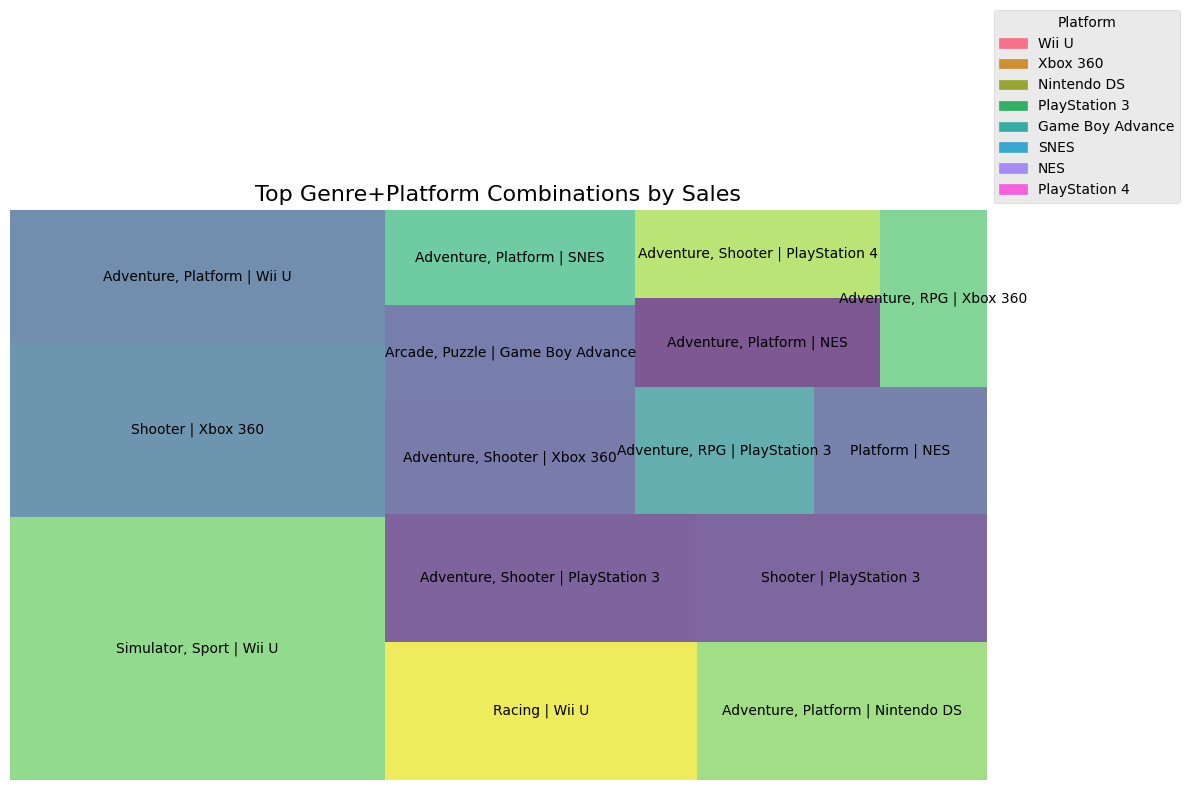

In [136]:
import squarify
# 10. Top Genre+Platform Combinations (Fixed Treemap)
genre_platform = merged_data.groupby(['genres', 'platform'])['global_sales'] \
                 .sum().nlargest(15).reset_index()
genre_platform['label'] = genre_platform['genres'] + ' | ' + genre_platform['platform']

plt.figure(figsize=(12, 8))
squarify.plot(sizes=genre_platform['global_sales'].values,
              label=genre_platform['label'].values,
              alpha=0.7,
              text_kwargs={'fontsize':10})
plt.title('Top Genre+Platform Combinations by Sales', fontsize=16)
plt.axis('off')

# Create custom legend for platforms
unique_platforms = genre_platform['platform'].unique()
colors = sns.color_palette("husl", len(unique_platforms))
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) 
           for i in range(len(unique_platforms))]
plt.legend(handles, unique_platforms, 
           title='Platform', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()